## Error and Correlation for test concepts using weights from Exp 1C

In [1]:
# Initialize these:

path = "E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads"   #<Replace the path here>
typeImg = "test"

sz = 100
numColors = 37  # Uses BCP-37 colors

In [2]:
# # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import time

In [3]:
colNames = ["col_"+str(i) for i in range(numColors)] 
allConcepts = ["Paper", "Plastic", "Trash", "Compost", "Metal","Glass"]

# # Read data
# # Get the color ratings data -From file data_clean.csv
data = pd.read_csv("TestScripts/data_test.csv",names = colNames)

# Get the LAB coordinates of colors from file Lab_test.csv ---> Uses BCP-37 colors

colorData = pd.read_csv("TestScripts/Lab_test.csv",header=None)
colorDataRGB = pd.read_csv("TestScripts/RGB_test.csv",header=None)

category = pd.read_csv("TestScripts/Category_test.csv",header=None) # COlor Category of BCP-37 colors

In [4]:
data

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36
0,0.13510,0.30566,0.25250,0.20077,0.21622,0.45617,0.38230,0.24153,0.29612,0.51005,...,0.25852,0.16832,0.34235,0.26056,0.14352,0.162450,0.43541,0.73454,0.94781,0.99816
1,0.25500,0.28179,0.25704,0.20066,0.28949,0.32163,0.28429,0.15857,0.32000,0.33602,...,0.38342,0.25633,0.27168,0.24730,0.21372,0.303670,0.53347,0.72061,0.77847,0.78633
2,0.13031,0.21107,0.23602,0.37719,0.25760,0.28020,0.40837,0.75372,0.22796,0.31219,...,0.32526,0.10612,0.14628,0.19806,0.18719,0.745410,0.74628,0.67842,0.45653,0.29219
3,0.10582,0.22423,0.29704,0.35684,0.26128,0.35179,0.52622,0.82592,0.30607,0.32730,...,0.29531,0.11332,0.13485,0.14832,0.18597,0.498110,0.59270,0.58827,0.37031,0.30015
4,0.11036,0.15791,0.18842,0.28520,0.15138,0.14964,0.22046,0.38776,0.16041,0.21454,...,0.32449,0.11245,0.11653,0.13684,0.12036,0.659640,0.94730,0.91128,0.65408,0.42536
5,0.11704,0.18582,0.21806,0.15286,0.16092,0.28347,0.28434,0.13255,0.19444,0.33439,...,0.47577,0.12173,0.30408,0.21148,0.12449,0.095255,0.44714,0.65577,0.79760,0.73745


In [5]:
# Count total number of images
count = 0
for i in allConcepts:
    print(path + "/" +typeImg +"/" +i+"/*.*")
    trainFiles = glob.glob( path + "/" +typeImg +"/" +i+"/*.*" )
    count = count + len(trainFiles[:50])
    #print(count)
print("Category: ",typeImg)
print("Total images : ",count)

E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads/test/Paper/*.*
E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads/test/Plastic/*.*
E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads/test/Trash/*.*
E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads/test/Compost/*.*
E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads/test/Metal/*.*
E:/GitRepo/Color-Concept-Associations-using-Google-Images/downloads/test/Glass/*.*
Category:  test
Total images :  300


## Extracting features from test Images

#### Features to be extracted are from Exp 1C

In [6]:
import matlab.engine
def getCategoriesMatrix(imageFileName,sz):
    ## Get total pixel counts of all 11 categories for this imageFile
    eng = matlab.engine.start_matlab()
    imageCat = np.array(eng.getCategories(imageFileName,sz))
    eng.quit()
     # imageCat : sz x sz matrix where each pixel has its category
    return imageCat

def getSegmentedImage(imageFileName,sz): # Returns segmented pixels in LAB and its corresponding color category.
    eng = matlab.engine.start_matlab()
    segImg, segImgCat = eng.activeContourSegmentation(imageFileName,sz, nargout=2)
    eng.quit()
    segImg = np.array(segImg)/255;
    segImg = skcolor.rgb2lab(segImg)
    segImgCat = np.array(segImgCat)
    return segImg, segImgCat


In [8]:
numFt = 3
X = np.zeros((count*numColors,numFt+1) )  # +1 for label #Number of features [] # Feature Vector -- 58N rows
init = time.time()
rowNum = -1
strtInd = []  # To keep track of the starting indices of concepts in the feature matrix
cvInd = 1 
counter = 0
sz = 100    # Size of image: 100 by 100

Rc = [1,10,20,30,40]   # Radii thresholds - not required
Li = [40]              #[1, 10, 20, 30, 40]
R = [40]               #[1, 10, 20, 30, 40]     # same as L
hueAngle = [40]        #[5, 10, 20, 30, 40] # Hue Angle
##
for conceptNum,concept in enumerate(allConcepts):
    #conceptNum = 5
    t0 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>\n",conceptNum+1,": Concept : ",concept)
    # Get label for corresponding concept (for given color)
    #label = data.loc[conceptNum]['col_'+str(color)]
    ct = 0    # Keeps track of images inside a category
    strtInd.append(counter)
    trainFiles = glob.glob( path + "/" +typeImg +"/" +concept+"/*.*" )
    print("\tTotal number of images for ",concept," : ",len(trainFiles))
    t = []
    for m, nameFile in enumerate(trainFiles[:50]):
        t1 = time.time()
        #print("\nReading file ......")
        ct = ct + 1
        
        image = imread( nameFile )
        imageResized = resize( image, (sz,sz),anti_aliasing=True,mode='reflect')
        img = imageResized
        # Convert the pixels in  image to LAB space
        imgLAB = skcolor.rgb2lab(img)
        segmentedImg,segmentedImgCat = getSegmentedImage(nameFile,sz)
        imageWithCategories = getCategoriesMatrix(nameFile,sz)
        
        i1 = imgLAB[27:72,27:72,:] 
        i6 = np.copy(segmentedImg)
        
        ii1 = imageWithCategories[27:72,27:72].flatten()
        
        categoryImg1 = [sum(1 for p in ii1 if p-1 == k)/ii1.size for k in range(11)]
      
        for color in range(numColors):
            rowNum+=1
            counter += 1
            colCt = 0
            colorLAB = np.array(colorData.loc[color])   #get LAB values for specific color

            # Just need 2 features from Sectors
            for i in [0,5]:
                if i == 0:
                    L = i1[:,:,0]
                    a = i1[:,:,1]
                    b = i1[:,:,2]
                elif i == 1:
                    L = i2[:,:,0]
                    a = i2[:,:,1]
                    b = i2[:,:,2]
                elif i == 2:
                    L = i3[:,:,0]
                    a = i3[:,:,1]
                    b = i3[:,:,2]
                elif i == 3:
                    L = i4[:,:,0]
                    a = i4[:,:,1]
                    b = i4[:,:,2]
                elif i == 4:
                    L = i5[:,:,0]
                    a = i5[:,:,1]
                    b = i5[:,:,2]
                else:
                    L = i6[:,:,0]
                    a = i6[:,:,1]
                    b = i6[:,:,2]
                    
                LTemp = L.flatten()
                r = np.sqrt(a**2+b**2).flatten()
                theta = np.degrees(np.arctan2(b,a)).flatten()

                L_diff = np.abs(LTemp - colorLAB[0])
                r_diff = np.abs(r - (np.sqrt(colorLAB[1]**2 + colorLAB[2]**2)))
                theta_diff = np.abs(theta - np.degrees(np.arctan2(colorLAB[2],colorLAB[1])))

                for j,r_th in enumerate(R):
                    l_th = Li[j] # L and R are the same.
                    for theta_th in hueAngle:
                        pixels = 0
                        for p in range(len(L_diff)):
                            if (L_diff[p] <= l_th and r_diff[p] <= r_th and theta_diff[p] <= theta_th) or (L_diff[p] <= l_th and r_diff[p] <= 2.5):
                                pixels += 1
                        X[rowNum,colCt] = pixels/(len(L_diff))
                        colCt+=1
            #print(colCt)
            
            colorCat = category.loc[color,0] 
            X[rowNum,colCt] = categoryImg1[colorCat-1]
            colCt+=1

            label = data.loc[conceptNum]['col_'+str(color)]   
            X[rowNum,colCt] = label
            #print(colCt)
        h = time.time()-t1
        print("\t\t",m, "image: ",h ," seconds")
        t.append(h)
    print(t)
    print("\t** Time elapsed since last category: ",time.time()-t0," seconds **")
strtInd.append(len(X))
print(strtInd)
print("** Total Time elapsed: ",time.time()-init," seconds **")

In [9]:
## convert your array into a dataframe
xxTemp = np.copy(X)
#y = np.copy(X[:,-1])
df = pd.DataFrame(xxTemp)
## save to xlsx file

filepath = 'dataTEST50.xlsx'
df.to_excel(filepath, index=False)
tot = len(xxTemp)

# Analysis

In [7]:
# Using strtInd from previous cells
strtInd = [0, 1850, 3700, 5550, 7400, 9250, 11100]

In [8]:
filepath = 'dataTEST50.xlsx'
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(11100, 4)

In [9]:
len(Q)

11100

In [10]:
Xtest = np.column_stack([np.ones((len(Q),1)), Q[:,:-1]])
ytest = np.copy(Q[:,-1])

# Weights from getWeightsAllFruits.ipynb  -- Model used entire fruit data for training
weights = [0.13629966, 0.13731228, 0.12712168, 0.31100729]

In [11]:
y_predAll = Xtest.dot(weights)

In [12]:
ytest.shape

(11100,)

In [13]:
from scipy import stats
plt.close('all')
win0_50 = []
win1_50 = []
win2_50 = []

correlation_50 = []
error_50 = []

for i in range(len(strtInd)-1):
    # Leave one entire fruit group
    testFruit =  allConcepts[i]
    #print("\nLeaving out fruit group : ",allConcepts[i])
    y_pred = np.copy(y_predAll[strtInd[i]:strtInd[i+1]])
    y_test = np.copy(ytest[strtInd[i]:strtInd[i+1]])
    print(y_pred.shape)
    totalTestImages = y_pred.size/numColors  #37N rows -> every image has 37 rows of data
    avg_pred =[np.sum([y_pred[p] for p in range(q,y_pred.size,numColors)])/totalTestImages for q in range(numColors)]

    # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
    trueRating = np.copy(y_test[0:numColors])
    
    sqErr = np.sum(pow(avg_pred - trueRating,2))
    print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)
    
    corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
    
    print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
    print("p-value %.4f" %pVal)

    error_50.append(sqErr)
    correlation_50.append(corrCoeff)
    win0_50.append(corrCoeff) # saves correlation for test fruit
    win1_50.append(trueRating) # saves true rating for test fruit
    win2_50.append(avg_pred)   # saves avg predicted rating for test fruit
    # Plot average color rating over all test images.
#     fig= plt.figure(figsize=(10,3))
#     barPlot = plt.bar(range(1,numColors+1),avg_pred,color = colorDataRGB.values,edgeColor = [0, 0, 0])
#     plt.ylabel('Ratings')
#     plt.xlabel('Colors')
#     plt.title('Predicted color ratings for Concept : %s' %testFruit)
#     plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
#     plt.ylim(0,1)
#     plt.show()

#     fig= plt.figure(figsize=(10,3))
#     barPlot = plt.bar(range(1,numColors+1), trueRating,color = colorDataRGB.values,edgeColor = [0, 0, 0])
#     plt.ylabel('Ratings')
#     plt.xlabel('Colors')
#     plt.title('True color ratings for Concept : %s' %testFruit)
#     plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
#     plt.ylim(0,1)
#     plt.show()

#     # Scatter plot
#     fig2 = plt.figure(figsize=(7,7))
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,s=80,marker = 'o',linewidths=0.5,edgeColor = [0, 0, 0])
#     plt.ylabel('Predicted Ratings')
#     plt.xlabel('Subject Ratings')
#     plt.title('Scatter plot of color ratings for : %s' %testFruit)
#     plt.axis('equal')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.show() 

(1850,)
The true squared error (in color ratings) for left out fruit Paper is: 1.9045

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8790
p-value 0.0000
(1850,)
The true squared error (in color ratings) for left out fruit Plastic is: 1.4076

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4045
p-value 0.0130
(1850,)
The true squared error (in color ratings) for left out fruit Trash is: 1.9419

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5148
p-value 0.0011
(1850,)
The true squared error (in color ratings) for left out fruit Compost is: 1.8387

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6638
p-value 0.0000
(1850,)
The true squared error (in color ratings) for left out fruit Metal is: 0.7908

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8720
p-value 0.0000
(1850,)
The true squa

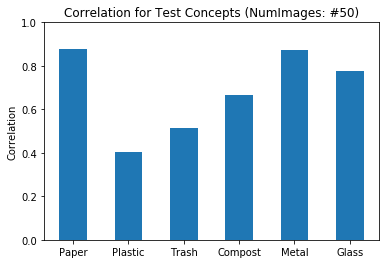

In [14]:
plt.close('all')
barWidth = 0.5
plt.bar(range(1,7),win0_50, width = barWidth)
plt.xticks(range(1,7),allConcepts)
plt.title("Correlation for Test Concepts (NumImages: #50)")
plt.ylabel('Correlation')
plt.ylim(0,1)
plt.show()

In [15]:
correlation_50

[0.8790331730315011,
 0.4045347055986854,
 0.5147702727844408,
 0.6637680050643039,
 0.8719657034761863,
 0.7742593107964867]

In [16]:
correlation_50

[0.8790331730315011,
 0.4045347055986854,
 0.5147702727844408,
 0.6637680050643039,
 0.8719657034761863,
 0.7742593107964867]

In [17]:
allConcepts

['Paper', 'Plastic', 'Trash', 'Compost', 'Metal', 'Glass']

# Save obtained ratings as csv

In [19]:
# conceptNames = []
# colorRow = []
# for i in range(len(allConcepts)):
#     for j in range(numColors):
#         conceptNames.append(allConcepts[i])
#         colorRow.append(j+1)

# matrix = np.column_stack((np.array(conceptNames), np.array(colorRow), np.array(win1_50).flatten(), np.array(win2_50).flatten()))
# print(matrix.shape)

# df = pd.DataFrame(matrix)
# ## save to xlsx file
# #print(df.head())
# filepath = 'RatingsTestConcepts.csv'
# df.to_csv(filepath, index=False)


(222, 4)


# Scatter Plots 

In [20]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,numImages):
    model_num = 3
    print("----------------------- Creating plots for Model ---------------Sector+Category")
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')
    plt.subplots(2,3,figsize=(5,4))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(2,3,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',s=15) #, edgecolor = [0,0,0])
        if k == 1 or k == 4:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    plotName = "Test_ScatterPlot_Model_"+str(numImages)+".pdf"
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    #plt.savefig(plotName, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    


----------------------- Creating plots for Model ---------------Sector+Category


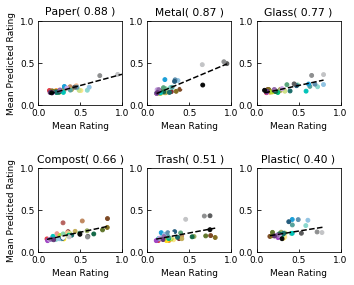

In [21]:
indices = np.argsort(win0_50)
createScatterPlots(indices, win0_50, win1_50, win2_50,50)

# Analysis using just top 5

In [23]:
numColors

37

In [24]:
from scipy import stats
plt.close('all')
win0_5 = []
win1_5 = []
win2_5 = []

correlation_5 = []
error_5 = []

for i in range(len(strtInd)-1):
    # Leave one entire fruit group
    testFruit =  allConcepts[i]
    #print("\nLeaving out fruit group : ",allConcepts[i])
    y_pred = np.copy(y_predAll[strtInd[i]:strtInd[i]+(5*numColors)])
    
    y_test = np.copy(ytest[strtInd[i]:strtInd[i]+(5*numColors)])
    print(y_pred.shape)
    totalTestImages = y_pred.size/numColors  #37N rows -> every image has 37 rows of data
    print("Total test images: ",  totalTestImages)
    avg_pred = np.array([np.sum([y_pred[p] for p in range(q,y_pred.size,numColors)])/totalTestImages for q in range(numColors)])
    #print(avg_pred)
    # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
    trueRating = np.copy(y_test[0:numColors])
   
    sqErr = np.sum(pow(avg_pred - trueRating,2))
    print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)
    
    corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
    
    print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
    print("p-value %.4f" %pVal)

    error_5.append(sqErr)
    correlation_5.append(corrCoeff)
    win0_5.append(corrCoeff) # saves correlation for test fruit
    win1_5.append(trueRating) # saves true rating for test fruit
    win2_5.append(avg_pred)   # saves avg predicted rating for test fruit
    # Plot average color rating over all test images.
#     fig= plt.figure(figsize=(10,3))
#     barPlot = plt.bar(range(1,numColors+1),avg_pred,color = colorDataRGB.values,edgeColor = [0, 0, 0])
#     plt.ylabel('Ratings')
#     plt.xlabel('Colors')
#     plt.title('Predicted color ratings for Concept : %s' %testFruit)
#     plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
#     plt.ylim(0,1)
#     plt.show()

#     fig= plt.figure(figsize=(10,3))
#     barPlot = plt.bar(range(1,numColors+1), trueRating,color = colorDataRGB.values,edgeColor = [0, 0, 0])
#     plt.ylabel('Ratings')
#     plt.xlabel('Colors')
#     plt.title('True color ratings for Concept : %s' %testFruit)
#     plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
#     plt.ylim(0,1)
#     plt.show()

#     # Scatter plot
#     fig2 = plt.figure(figsize=(7,7))
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,s=80,marker = 'o',linewidths=0.5,edgeColor = [0, 0, 0])
#     plt.ylabel('Predicted Ratings')
#     plt.xlabel('Subject Ratings')
#     plt.title('Scatter plot of color ratings for : %s' %testFruit)
#     plt.axis('equal')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.show() 

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Paper is: 2.1153

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7744
p-value 0.0000
(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Plastic is: 1.2367

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4694
p-value 0.0034
(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Trash is: 2.0674

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.3525
p-value 0.0324
(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Compost is: 1.7903

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6196
p-value 0.0000
(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Metal is: 1.3336

Pearson’s corr

In [25]:
correlation_5

[0.7744189958617475,
 0.4694308729563639,
 0.35249764961795593,
 0.6195785129744772,
 0.480675315367816,
 0.5081141498268638]

In [26]:
correlation_50

[0.8790331730315011,
 0.4045347055986854,
 0.5147702727844408,
 0.6637680050643039,
 0.8719657034761863,
 0.7742593107964867]

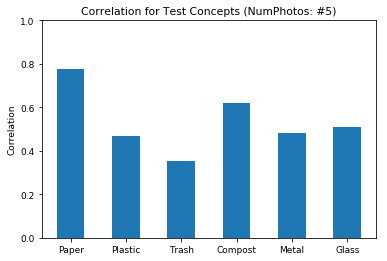

In [27]:
barWidth = 0.5
plt.bar(range(1,7),win0_5, width = barWidth)
plt.xticks(range(1,7),allConcepts)
plt.title("Correlation for Test Concepts (NumPhotos: #5)")
plt.ylabel('Correlation')
plt.ylim(0,1)
plt.show()

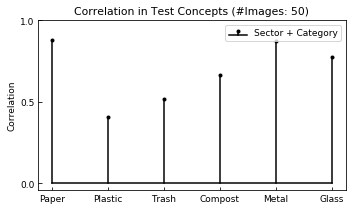

In [28]:
plt.close('all')
barWidth = 0.1
#r1 = [0.4,0.8,1.2,1.6,2,2.4]
r1 = [0.1,0.4,0.7,1,1.3,1.6]
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(5,3)) # (3,1.5)

mline3 = plt.stem(r1,correlation_50,label='Sector + Category')
plt.setp(mline3, color=[0,0,0], linewidth=1.5, markersize = 3)

plt.xticks(r1,allConcepts)
plt.yticks([0,0.5,1])
plt.tick_params(direction='in')
plt.title("Correlation in Test Concepts (#Images: 50)")
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
#plt.savefig('Exp3_Correlation.pdf')
plt.show()


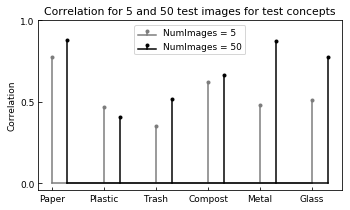

In [29]:
plt.close('all')
barWidth = 0.3
r1 = range(1,7)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(5,3)) # (12,6)
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
# mline1 = plt.stem(r1,[topErr[0],photoErr[0],cartErr[0]], linefmt='-',label='Model 1')
# plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.5, markersize = 3)
# #plt.setp(sline1, linewidth=0.8)


mline2 = plt.stem(r1,correlation_5,label='NumImages = 5')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.5, markersize = 3)

mline3 = plt.stem(r2,correlation_50,label='NumImages = 50')
plt.setp(mline3, color=[0,0,0], linewidth=1.5, markersize = 3)


plt.xticks(r1,allConcepts)
plt.yticks([0,0.5,1])
plt.tick_params(direction='in')
plt.title("Correlation for 5 and 50 test images for test concepts")
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
plt.savefig('Exp3_DiffNumImages_Correlation.pdf')
plt.show()


In [30]:
error_50

[1.9045026446424025,
 1.4076266029489202,
 1.9418757448954855,
 1.8386901928749555,
 0.7907879764918057,
 2.054761369384326]

In [31]:
error_5

[2.115309087144997,
 1.2367095695217631,
 2.0674318017128614,
 1.7902595144135167,
 1.3336177913316383,
 2.4093777416685067]

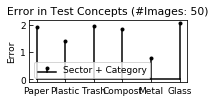

In [32]:
plt.close('all')
barWidth = 0.1
#r1 = range(1,7)
r1 = [0.1,0.4,0.7,1,1.3,1.6]
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(3,1.5)) # (12,6)
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
# mline1 = plt.stem(r1,[topErr[0],photoErr[0],cartErr[0]], linefmt='-',label='Model 1')
# plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.5, markersize = 3)
# #plt.setp(sline1, linewidth=0.8)


# mline2 = plt.stem(r1,[topErr[1],photoErr[1],cartErr[1]],label='Model 2')
# plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.5, markersize = 3)

mline3 = plt.stem(r1,error_50,label='Sector + Category')
plt.setp(mline3, color=[0,0,0], linewidth=1.5, markersize = 3)

plt.xticks(r1,allConcepts)
plt.yticks([0,1,2])
plt.tick_params(direction='in')
plt.title("Error in Test Concepts (#Images: 50)")
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.savefig('Exp3_Error.pdf')
plt.show()


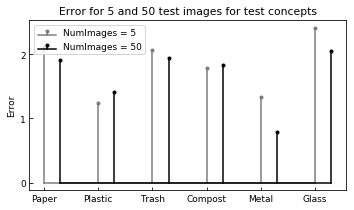

In [33]:
plt.close('all')
barWidth = 0.3
r1 = range(1,7)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(5,3)) # (12,6)
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
# mline1 = plt.stem(r1,[topErr[0],photoErr[0],cartErr[0]], linefmt='-',label='Model 1')
# plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.5, markersize = 3)
# #plt.setp(sline1, linewidth=0.8)


mline2 = plt.stem(r1,error_5,label='NumImages = 5')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.5, markersize = 3)

mline3 = plt.stem(r2,error_50,label='NumImages = 50')
plt.setp(mline3, color=[0,0,0], linewidth=1.5, markersize = 3)

plt.xticks(r1,allConcepts)
plt.yticks([0,1,2])
plt.tick_params(direction='in')
plt.title("Error for 5 and 50 test images for test concepts")
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
#plt.savefig('Exp3_DiffNumImages_Error.pdf')
plt.show()


In [34]:
correlation_50

[0.8790331730315011,
 0.4045347055986854,
 0.5147702727844408,
 0.6637680050643039,
 0.8719657034761863,
 0.7742593107964867]

In [37]:
cor_50,_ = stats.pearsonr(np.array(win2_50).flatten(), np.array(win1_50).flatten())
cor_5,_ = stats.pearsonr(np.array(win2_5).flatten(), np.array(win1_5).flatten())

In [38]:
print("Overall correlation for top 50 is:",cor_50)
print("Overall correlation for top 5 is:",cor_5)

Overall correlation for top 50 is: 0.6779810574212304
Overall correlation for top 5 is: 0.4755170131042525
